In [1]:
!kaggle datasets download -d teajay/global-shark-attacks


  0%|          | 0.00/548k [00:00<?, ?B/s]
100%|##########| 548k/548k [00:00<00:00, 5.39MB/s]
100%|##########| 548k/548k [00:00<00:00, 5.34MB/s]


In [2]:
!tar -xzvf global-shark-attacks.zip

x attacks.csv


In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import re
import collections

In [4]:
data = pd.read_csv("data\\data_year.csv", encoding='cp1252')

## 1. Basic Analysis

In [33]:
data.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2018.06.25,25-Jun-2018,2018.0,Boating,USA,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,...,White shark,"R. Collier, GSAF",2018.06.25-Wolfe.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.25,2018.06.25,6303.0,NaN,NaN
1,2018.06.18,18-Jun-2018,2018.0,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,Adyson McNeely,F,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.18-McNeely.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.18,2018.06.18,6302.0,NaN,NaN
2,2018.06.09,09-Jun-2018,2018.0,Invalid,USA,Hawaii,"Habush, Oahu",Surfing,John Denges,M,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.09-Denges.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.09,2018.06.09,6301.0,NaN,NaN
3,2018.06.08,08-Jun-2018,2018.0,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,male,M,...,2 m shark,"B. Myatt, GSAF",2018.06.08-Arrawarra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.08,2018.06.08,6300.0,NaN,NaN
4,2018.06.04,04-Jun-2018,2018.0,Provoked,MEXICO,Colima,La Ticla,Free diving,Gustavo Ramos,M,...,"Tiger shark, 3m",A .Kipper,2018.06.04-Ramos.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.04,2018.06.04,6299.0,NaN,NaN


In [50]:
data.shape

(25723, 24)

In [35]:
data.columns

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')

The dataset contains a number of columns that wont be relevant for the analysis, like "pdf" of "href formula", and others whose meaning cannot be interpreted easily, like "Unnamed 22" or "Original order". This columsn can be dropped as they wont be useful. Also, the column "Case Number" and "Date" seem to contain the same date information with different formats, so we can delete one of them and work with the other. 

In [4]:
data = data.drop(["Date","Name","Investigator or Source","pdf","href formula","href","Case Number.1","Case Number.2",
                 "original order","Unnamed: 22", "Unnamed: 23"], axis=1)

### NaN values

In [81]:
data.isnull().sum()

Case Number    17021
Year           19423
Type           19425
Country        19471
Area           19876
Location       19961
Activity       19965
Sex            19986
Age            22252
Injury         19449
Fatal (Y/N)    19960
Time           22775
Species        22259
dtype: int64

There is a great number of rows that contain a lot of Nan values. An way to deal with them would be to drop all rows that have a 100% of NaN values, however, there are rows that have many NaN values without reaching the 100%. In order keep the maximun amount of information possible,the **thresh** parameter of the **dropna()** built-in function will be used to determine the maximum number of NaN values allowed per row. In this case the parameter will be set to 6

In [5]:
data = data.dropna(axis=0, thresh=6)

In [170]:
data.shape

(6301, 13)

With this, we have deleted around 19,000 rows of the dataset, almost 4/5 of the total

### How to treat the remaining NaN values?

There are different ways to fill the NaN values in a dataset, and each one depends on a series of factors like the type of the column, the kind of analysis, etc. In this case, two approaches are going to be taken. Those NaN values in string type columns are going to be replaced by **Unknown**, as it is something that should not be guessed nor inferred. In the case of data tyoe columns, even though they have not yet been transformed, are going to be repalced with the previous value because it can be assumed that they follow a certain order

#### When trying to replace the NaN values of categorical columns, there is an error related to the **Species** column, at is because it has a white space at the end. This can be solved later, but in order to have all the columns with the same format lets do it now

In [104]:
data.rename(columns={"Species ":"Species"},inplace  =True)

In [102]:
data.rename(columns={"Sex ":"Sex"}, inplace=True)

In [105]:
data.rename(columns={"Fatal (Y/N)":"Fatal"},inplace=True)

In [107]:
data.rename(columns={"Case Number":"Case_Number"},inplace=True)

In [7]:
#Replace the NaN with Unknown of categorical values (object)
data[["Type", "Country", "Area", "Activity", "Injury"
            ,"Sex ", "Fatal (Y/N)", "Species"]] = data[["Type", "Country", "Area", "Activity", "Injury"
                         ,"Sex ", "Fatal (Y/N)","Species"]].fillna("Unknown") 

In [8]:
#In the case of 'Year' and 'Time' we're going to fill NaN values with the previous one, as we assume that they
#follow a certain order, and doing this is better that filling them with 'NONE'

data[["Case Number","Time", "Year"]] = data[["Case Number","Time", "Year"]].fillna(method = 'ffill')

## 2. Column Analysis

Now, lets check each of the colums to see what corrections need to be done

### **Year**

In [9]:
def sorting(data):
    return data.sort_values(ascending = True)

In [10]:
def counts(column):
    '''
    This function returns the value_counts() result of a column as a dictionary sorted by key in ascending order.
    Easier to examine.
    Args: the column of interest in the format of df.column or df["columnd"]
    '''
    s = (column.value_counts())
    dictionary =  s.to_dict()
    return collections.OrderedDict(sorted(dictionary.items()))

In [100]:
year = counts(data.Year)

The first thing that should be noticed is that ther a 125 attack in year 0, which makes no sense. Also, there are records of attacks taking place in years that are too ancient. This may be typing errors, so, instead of deleting all those records, and losing all the information, when analyzing the **Year** column a threshold will be set to avoid taking this attypical years into account

It should also be mentioned that the years have decimals, which is not possible. Therefore, lets remove them.

In [11]:
data.Year = data.Year.astype('int32')

In [101]:
# The df has been safed as a csv so that the progress is not lost if jupyter notebook is closed 
data.to_csv(r'C:\Users\juanp\proyectos_varios\shark_attacks\data\data_regex.csv' , index = True)

## Plots and Visualizations

In [167]:
from ipywidgets import interact
import cufflinks as cf
from IPython.display import display,HTML
cf.set_config_file(sharing='public',theme='ggplot',offline=True)
import plotly.express as px

In [55]:
aggresive_sharks = data[data.groupby('shark_species')['shark_species'].transform('size') > 40]

In [143]:
data = pd.read_csv('data\\data_coords.csv')

In [164]:
shark_count = data.groupby('shark_species').agg({'Injury':'count', 'fatal_injury':'sum'})

In [166]:
shark_count.reset_index(inplace = True)

In [128]:
shark_count.iplot(kind='bar', color = 'lightgreen')

[Text(0, 0, 'white shark'),
 Text(1, 0, 'tiger shark'),
 Text(2, 0, 'bull shark'),
 Text(3, 0, 'nurse shark'),
 Text(4, 0, 'wobbegong shark'),
 Text(5, 0, 'blacktip shark'),
 Text(6, 0, 'blue shark'),
 Text(7, 0, 'spinner shark'),
 Text(8, 0, 'mako shark'),
 Text(9, 0, 'bronze whaler'),
 Text(10, 0, 'hammerhead shark'),
 Text(11, 0, 'raggedoth shark')]

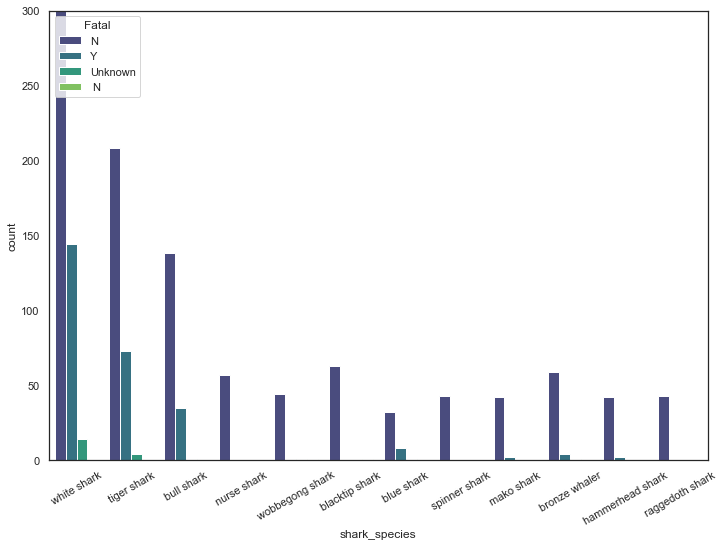

In [93]:
sns.set(rc={'figure.figsize':(11.8,8.27)})
sns.set_style('white')
pl = sns.countplot(x=aggresive_sharks.shark_species, hue = aggresive_sharks.Fatal, palette="viridis")
pl.set(ylim=(0,300))
pl.set_xticklabels(pl.get_xticklabels(),rotation = 30)

### Geographical Visualization 

In [161]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2,map_countries
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

In [7]:
def get_country_code(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    return cn_a2_code

In [8]:
def get_continent(col):
    try:
        cn_continent = country_alpha2_to_continent_code(col)
    except:
        cn_continent = 'Unknown' 
    return cn_continent

In [9]:
data['country_code'] = list(map(get_country_code,data.Country))

In [10]:
data['continent'] = list(map(get_continent,data.country_code))

In [5]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='my_application')

In [37]:
geolocator = Nominatim(user_agent="your_app_name")
geolocator.geocode('Spain').latitude

39.3260685

In [12]:
lat = []
long = []
geolocator = Nominatim(user_agent="your_app_name")
def latitude_coord(col):
    return geolocator.geocode(col).latitude

def longitude_coord(col):
    geolo

In [13]:
for i in data.Country:
    try:
        lat.append(latitude_coord(i))
    except: 
        lat.append('Unknown')

In [16]:
for i in data.Country:
    try:
        long.append(geolocator.geocode(i).longitude)
    except: 
        long.append('Unknown')

In [15]:
data['lat'] = lat

In [36]:
data['long'] = long

In [40]:
data.to_csv(r'C:\Users\juanp\proyectos_varios\shark_attacks\data\data_coords.csv' , index = False)

In [37]:
import geopandas, shapely
from shapely.geometry import Point
import geojson
with open('data\\countries.geojson') as f:
    gj = geojson.load(f)

In [58]:
gdp[gdp.Country== 'Australia'].head(1)

,Unnamed: 0,Case_Number,Year,Type,Country,Area,Location,Activity,Sex,Age,...,Time,Species,fatal_injury,shark_species,month_incident,country_code,continent,lat,long,geometry
3,3,2018.06.08,2018,Unprovoked,Australia,New South Wales,Arrawarra Headland,Surfing,M,NaN,...,07:45,shark,NaN,NaN,Jun,AU,OC,-24.776109,134.755,POINT (134.75500 -24.77611)


In [59]:
communities_geo = r'spain-communities.geojson'

# open the json file - json.load() methods returns a python dictionary
with open(communities_geo) as communities_file:
    communities_json = json.load(communities_file)

FileNotFoundError: [Errno 2] No such file or directory: 'spain-communities.geojson'

In [24]:
lat = list(data.lat)

In [26]:
long = list(data.long)

In [42]:
data.lat = data.lat.apply(lambda x: float(x) if x!= 'Unknown' else '')

In [43]:
data.long = data.long.apply(lambda x: float(x) if x!= 'Unknown' else '')

In [61]:
data_coords = data[(data.lat != 'Unknown') & (data.long != 'Unknown')]

In [67]:
gdp = geopandas.GeoDataFrame(
    data_coords, geometry=geopandas.points_from_xy(data_coords.long, data_coords.lat))


In [13]:
gdp = geopandas.GeoDataFrame(gdf, geometry=geopandas.points_from_xy(gdf.long, gdf.lat))

In [70]:
gdp.to_csv(r'C:\Users\juanp\proyectos_varios\shark_attacks\data\data_geoframe.csv' , index = False)

### Creating World Map

In [102]:
gdp.columns

Index(['Unnamed: 0', 'Case_Number', 'Year', 'Type', 'Country', 'Area',
       'Location', 'Activity', 'Sex', 'Age', 'Injury', 'Fatal', 'Time',
       'Species', 'fatal_injury', 'shark_species', 'month_incident',
       'country_code', 'continent', 'lat', 'long', 'geometry'],
      dtype='object')

In [181]:
data_fatal = gdp.groupby('Country').agg({'Type':'count','fatal_injury':'count','lat':'first', 'long':'first'})

In [182]:
data_fatal = pd.DataFrame(data_fatal)

In [183]:
data_fatal.reset_index(level=0, inplace=True)

In [184]:
data_fatal['fatal_perc'] = round((data_fatal.fatal_injury / data_fatal.Type)*100,2)

In [185]:
data_fatal_gdp = geopandas.GeoDataFrame(data_fatal, geometry=geopandas.points_from_xy(data_fatal.long, data_fatal.lat))

In [186]:
df_json = json.loads(data_fatal_gdp.to_json())

In [187]:
json_data = json.dumps(df_json)

In [188]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

In [189]:
geosource = GeoJSONDataSource(geojson=json_data)

In [190]:
palette = brewer['YlGnBu'][8]
palette = palette[::-1]
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 2000)

In [198]:
p = figure(plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

In [200]:
p.patches('xs','ys', source = geosource,
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
output_notebook()
show(p)

Loading BokehJS ...